## 데이터 클렌징 및 가공

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv("data/bike/train.csv")
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


datetime 칼럼은 object형이므로 datatime 타입으로 바꿔주기

In [9]:
# 문자열을 datetime 타입으로 변경.
train['datetime'] = train.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
train['year'] = train.datetime.apply(lambda x : x.year)
train['month'] = train.datetime.apply(lambda x : x.month)
train['day'] = train.datetime.apply(lambda x : x.day)
train['hour'] = train.datetime.apply(lambda x : x.hour)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


datetime 칼럼 삭제 및 casual(사전등록x) + registered(사전등록) = count 이므로 상관도가 높아 성능을 저해할수도 있으므로 삭제

In [10]:
drop_columns = ['datetime', 'casual', 'registered']
train.drop(drop_columns, axis=1, inplace=True)

## 이 대회의 평가지표는 RMSLE, 하지만 sklearn은 RMSLE 제공x
## MSE, RMSE, RMSLE까지 구해주는 함수를 만들기

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    score = rmsle_val
    rmse_val = rmse(y, pred)
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print("RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}".format(rmsle_val, rmse_val, mae_val))

## 로그 변환, 피처 인코딩과 모델 학습/예측/평가

먼저 선형회귀

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = train['count']
X_features = train.drop("count", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=37)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.182, RMSE: 140.778, MAE: 106.050


## 실제 값과 예측값이 어느 정도 차이가 나는지 확인하는 함수

In [15]:
def get_top_error_data(y_test, pred, n_tops=5):
    # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성.
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    # 예측값과 실제 값이 가장 큰 데이터 순으로 출력.
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

In [16]:
get_top_error_data(y_test, pred, n_tops = 5)

      real_count  predicted_count   diff
649          839            200.0  639.0
2937         809            198.0  611.0
2361         890            323.0  567.0
2938         888            326.0  562.0
2620         968            406.0  562.0


## 예측 오류차이가 크다.
## 이런 경우 가장 먼저 살펴볼 것은 Target 값의 분포가 왜곡됐는지 아닌지.
## Target의 값은 정규분포형태가 가장 좋다.

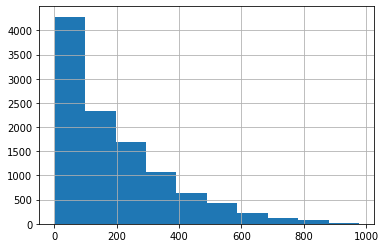

In [17]:
y_target.hist()

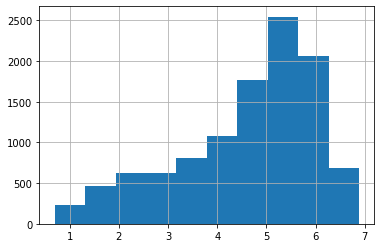

In [18]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [19]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=37)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.010, RMSE: 159.216, MAE: 106.748


## RMSLE는 줄었지만 RMSE가 늘어났다.
## 이를 확인해보고자 피처의 회귀 계수값 시각화

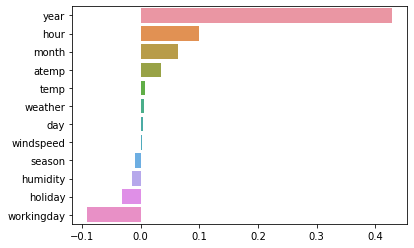

In [20]:
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## year는 카테고리형 피처지만 숫자형으로 나타나있으므로 원핫 인코딩

In [27]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

In [26]:
X_features_ohe

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10882,14.76,17.425,57,15.0013,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10883,13.94,15.910,61,15.0013,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10884,13.94,17.425,61,6.0032,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0


## 모델, 학습/테스트 데이터를 입력하면 성능 평가 수치 반환 함수

In [22]:
# 원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size = 0.3, random_state=37)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

## 선형, 릿지, 라쏘로 모델 평가 수행

In [29]:
# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


## 회귀 모델의 회귀 계수 상위 25

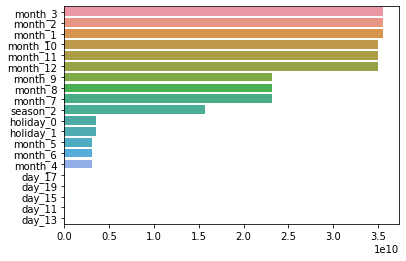

In [30]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y = coef_sort.index)

## 회귀 트리

In [31]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.332, MAE: 31.204
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.342, MAE: 32.747
[12:50:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.345, RMSE: 58.245, MAE: 35.768
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


In [36]:
get_model_predict(lgbm_reg, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


In [38]:
score

0

In [95]:
test = pd.read_csv("data/bike/test.csv")

In [96]:
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


In [97]:
# 문자열을 datetime 타입으로 변경.
test['datetime'] = test.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
test['year'] = test.datetime.apply(lambda x : x.year)
test['month'] = test.datetime.apply(lambda x : x.month)
test['day'] = test.datetime.apply(lambda x : x.day)
test['hour'] = test.datetime.apply(lambda x : x.hour)
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4


In [98]:
test.drop("datetime",axis=1,inplace=True)

In [99]:
test_ohe = pd.get_dummies(test, columns=['year', 'month','hour', 'holiday',
                                              'workingday','season','weather'])

In [101]:
test_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 55 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          6493 non-null   float64
 1   atemp         6493 non-null   float64
 2   humidity      6493 non-null   int64  
 3   windspeed     6493 non-null   float64
 4   day           6493 non-null   int64  
 5   year_2011     6493 non-null   uint8  
 6   year_2012     6493 non-null   uint8  
 7   month_1       6493 non-null   uint8  
 8   month_2       6493 non-null   uint8  
 9   month_3       6493 non-null   uint8  
 10  month_4       6493 non-null   uint8  
 11  month_5       6493 non-null   uint8  
 12  month_6       6493 non-null   uint8  
 13  month_7       6493 non-null   uint8  
 14  month_8       6493 non-null   uint8  
 15  month_9       6493 non-null   uint8  
 16  month_10      6493 non-null   uint8  
 17  month_11      6493 non-null   uint8  
 18  month_12      6493 non-null 

In [103]:
X = train.drop("count", axis=1)
y = train['count']

In [105]:
X_ohe = pd.get_dummies(X, columns=['year', 'month','hour', 'holiday',
                                              'workingday','season','weather'])

In [106]:
X_ohe

,temp,atemp,humidity,windspeed,day,year_2011,year_2012,month_1,month_2,month_3,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0000,1,1,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,19,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10882,14.76,17.425,57,15.0013,19,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10883,13.94,15.910,61,15.0013,19,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10884,13.94,17.425,61,6.0032,19,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0


In [107]:
test_ohe

,temp,atemp,humidity,windspeed,day,year_2011,year_2012,month_1,month_2,month_3,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,10.66,11.365,56,26.0027,20,1,0,1,0,0,...,0,1,1,0,0,0,1,0,0,0
1,10.66,13.635,56,0.0000,20,1,0,1,0,0,...,0,1,1,0,0,0,1,0,0,0
2,10.66,13.635,56,0.0000,20,1,0,1,0,0,...,0,1,1,0,0,0,1,0,0,0
3,10.66,12.880,56,11.0014,20,1,0,1,0,0,...,0,1,1,0,0,0,1,0,0,0
4,10.66,12.880,56,11.0014,20,1,0,1,0,0,...,0,1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,10.66,12.880,60,11.0014,31,0,1,0,0,0,...,0,1,1,0,0,0,0,1,0,0
6489,10.66,12.880,60,11.0014,31,0,1,0,0,0,...,0,1,1,0,0,0,0,1,0,0
6490,10.66,12.880,60,11.0014,31,0,1,0,0,0,...,0,1,1,0,0,0,1,0,0,0
6491,10.66,13.635,56,8.9981,31,0,1,0,0,0,...,0,1,1,0,0,0,1,0,0,0


In [108]:
y

0         16
1         40
2         32
3         13
4          1
        ... 
10881    336
10882    241
10883    168
10884    129
10885     88
Name: count, Length: 10886, dtype: int64

In [109]:
y_log = np.log1p(y)

In [110]:
lgbm_reg = LGBMRegressor(n_estimators=500)

In [111]:
lgbm_reg.fit(X_ohe, y_log)

LGBMRegressor(n_estimators=500)

In [112]:
lgbm_reg.predict(test_ohe)

array([2.47810176, 1.58822869, 1.4368277 , ..., 4.62017414, 4.55938637,
       3.95379855])

In [113]:
pred = lgbm_reg.predict(test_ohe)

In [115]:
pred = np.expm1(pred)

In [116]:
pred

array([ 10.9186185 ,   3.89507057,   3.20732773, ..., 100.51170753,
        94.52484446,  51.13302123])

In [117]:
pred = np.round(pred)

In [118]:
pred

array([ 11.,   4.,   3., ..., 101.,  95.,  51.])

In [119]:
submission = pd.read_csv("data/bike/sampleSubmission.csv")

In [120]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [121]:
submission['count'] = pred

In [122]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,11.0
1,2011-01-20 01:00:00,4.0
2,2011-01-20 02:00:00,3.0
3,2011-01-20 03:00:00,3.0
4,2011-01-20 04:00:00,2.0


In [123]:
submission.to_csv("data/bike/submission_{0}.csv".format(0.319), index=False)

In [124]:
X_ohe['day'] = X_ohe['day'].astype('category')

In [125]:
test_ohe['day'] = test_ohe['day'].astype('category')

In [126]:
X_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 55 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   temp          10886 non-null  float64 
 1   atemp         10886 non-null  float64 
 2   humidity      10886 non-null  int64   
 3   windspeed     10886 non-null  float64 
 4   day           10886 non-null  category
 5   year_2011     10886 non-null  uint8   
 6   year_2012     10886 non-null  uint8   
 7   month_1       10886 non-null  uint8   
 8   month_2       10886 non-null  uint8   
 9   month_3       10886 non-null  uint8   
 10  month_4       10886 non-null  uint8   
 11  month_5       10886 non-null  uint8   
 12  month_6       10886 non-null  uint8   
 13  month_7       10886 non-null  uint8   
 14  month_8       10886 non-null  uint8   
 15  month_9       10886 non-null  uint8   
 16  month_10      10886 non-null  uint8   
 17  month_11      10886 non-null  uint8   
 18  month_

In [127]:
lgbm_reg.fit(X_ohe, y_log)
lgbm_reg.predict(test_ohe)

array([2.33231913, 1.63660109, 1.27186417, ..., 4.76648666, 4.54729167,
       4.04391252])

In [128]:
pred = lgbm_reg.predict(test_ohe)

In [129]:
pred = np.expm1(pred)

In [130]:
pred = np.round(pred)

In [131]:
submission = pd.read_csv("data/bike/sampleSubmission.csv")
submission['count'] = pred
submission.to_csv("data/bike/submission_{0}.csv".format(0.3192), index=False)